# Valuation for Qlib Training

In [88]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

In [89]:
def rebalance():
    ...
def compute_ic():
    ...

In [90]:
%run ../factor/libs/performance.py

## Load Results

We first read all the results that qlib training genereted

In [92]:
exp_name = 'onlypred_test/oos'

# read result
path = Path(f'../data/intermediate/results/{exp_name}')
pred = pd.read_parquet(path)
pred = pred.loc[~pred.index.duplicated(keep='last')]

# read return data and benchmark data
ret = pd.read_parquet('../data/intermediate/forward_return/1d_open_open.parquet')
benchmark = pd.read_parquet('../data/index/zz500.parquet', columns=['ret'])
benchmark = benchmark.loc[pred.index.levels[0]]

# construct pred_label variable
pred_label = pd.concat([pred, ret], axis=1, join='inner')

## Rebalance by 1 Day

In [93]:
result = rebalance(pred_label, benchmark=benchmark)

### Layering Result

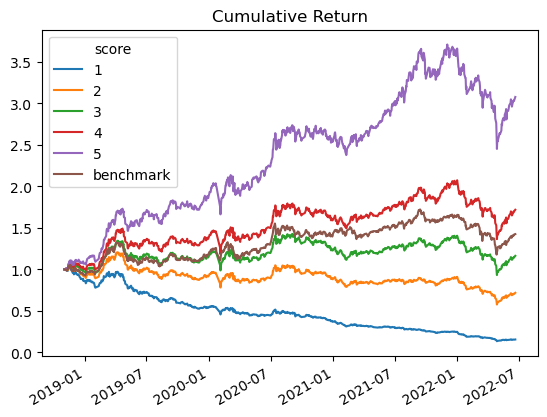

In [94]:
(result['profit'] + 1).cumprod().plot(title='Cumulative Return');

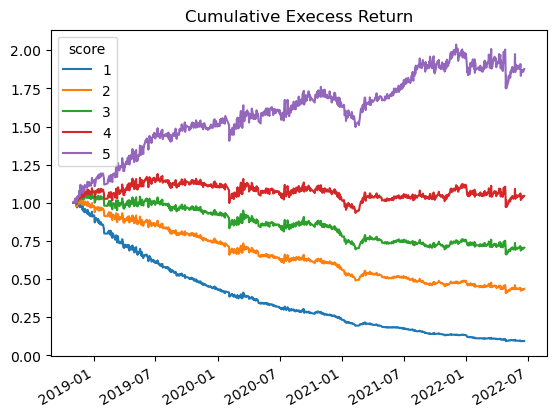

In [95]:
(result['exprofit'] + 1).cumprod().plot(title='Cumulative Execess Return');

In [96]:
annual_ret = (np.power((
        result['profit'].iloc[:, -2] + 1).cumprod().iloc[-1], 252 / len(result['profit']
    )) - 1) * 100
annual_exret = (np.power((
        result['exprofit'].iloc[:, -1] + 1).cumprod().iloc[-1], 252 / len(result['profit']
    )) - 1) * 100
print(f"Top Layer Average Annual Return: {annual_ret:.2f}%")
print(f"Top Layer Average Annual Execess Return: {annual_exret:.2f}%")

Top Layer Average Annual Return: 37.99%
Top Layer Average Annual Execess Return: 19.77%


### Draw Down

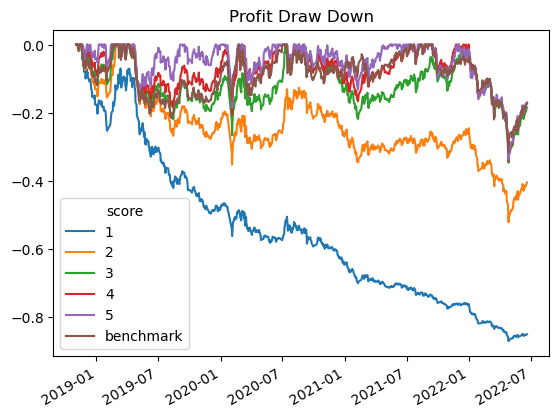

In [97]:
result['mmd'].plot(title='Profit Draw Down');

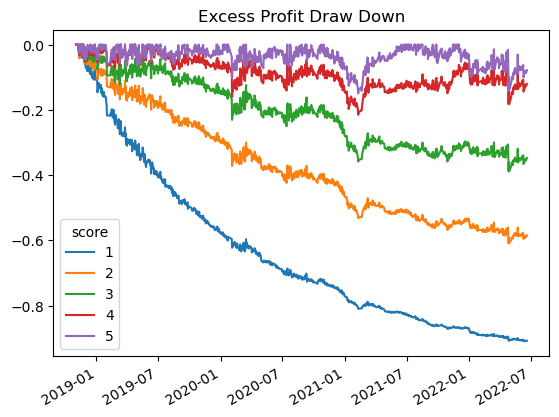

In [98]:
result['exmmd'].plot(title='Excess Profit Draw Down');

In [99]:
mmd = result['mmd'].iloc[:, -2].min() * 100
exmmd = result['exmmd'].iloc[:, -1].min() * 100
print(f"Top Layer Max Draw Down: {mmd:.2f}%")
print(f"Top Layer Excess Max Draw Down: {exmmd:.2f}%")

Top Layer Max Draw Down: -33.92%
Top Layer Excess Max Draw Down: -14.96%


## Turnover

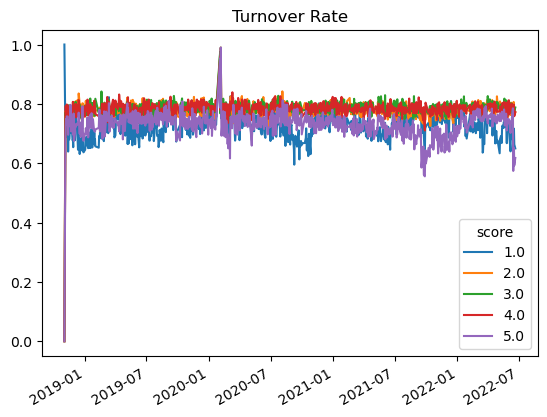

In [100]:
result['turnover'].plot(title='Turnover Rate');

## IC

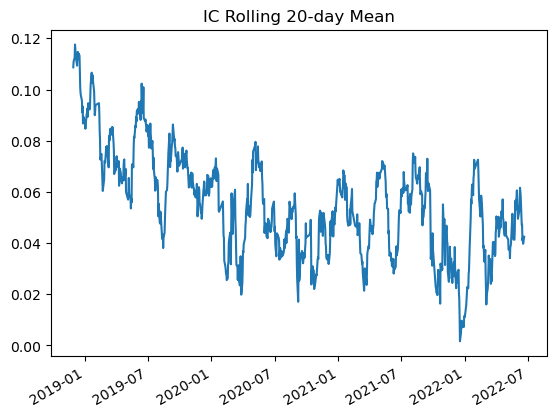

In [103]:
ic = compute_ic(pred_label)['ic']
ic.rolling(20).mean().plot(title='IC Rolling 20-day Mean');